<a href="https://colab.research.google.com/github/riubi/tests-math/blob/main/mathematical_statistics/ANOVA_homework_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание "Однофакторный дисперсионный анализ (ANOVA)"

**Инструкции:**
- Скачайте этот файл и заполните ячейки с кодом и текстовыми выводами.
- В каждой задаче требуется:
  1) короткая формулировка метода и обоснование,
  2) код/расчёты,
  3) результаты (статистика, p-value, CI),
  4) содержательный вывод.
- Используйте `scipy`, `statsmodels`, `pingouin` или `scikit-posthocs` по желанию. При нарушении допущений объясните, какие альтернативы применили.

Формат сдачи: `.ipynb` с заполненными ячейками и выводами.

In [66]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import FTestAnovaPower

### Задание 1. Сопоставление статистик

Вам предложены описания ситуаций и статистических процедур. Для каждой ситуации укажите наилучшую применимую статистику из списка: `z-test`, `t-test`, `Welch t-test`, `F-test` (сравнение дисперсий), `χ^2` (goodness-of-fit), `ANOVA (one-way)`, `Tukey HSD`, `Levene`.

Ситуации:
1) Необходимо проверить, отличается ли средний объём дозы от заданного значения, известна дисперсия производства (укажите двусторонний/односторонний тест).
2) Сравнить средние двух независимых групп при неизвестных, но равных дисперсиях.
3) Сравнить средние двух независимых групп при неизвестных и неравных дисперсиях.
4) Оценить, одинаковы ли средние в трёх и более группах.
5) Проверить, согласуются ли наблюдаемые частоты с распределением Пуассона.

**Требуется:** кратко объясните выбор для каждой ситуации (1—2 предложения).


Ответы на задание 1:

1) z-test (двусторонний или односторонний)
Дисперсия известна, поэтому используем z-критерий. Двусторонний - если проверяем отклонение в любую сторону, односторонний - если только в одну.

2) t-test (pooled)
Дисперсии неизвестны, но равны - используем обычный t-критерий Стьюдента с объединённой дисперсией.

3) Welch t-test
Дисперсии неизвестны и неравны - используем t-критерий Уэлча с поправкой на степени свободы.

4) ANOVA (one-way)
Для сравнения средних в трёх и более группах используем однофакторный дисперсионный анализ.

5) Хи-квадрат (goodness-of-fit)
Для проверки согласия частот с теоретическим распределением используем критерий хи-квадрат.

### Задание 2. Тест для дозатора (z-test, двусторонний)

Инженерная задача. Дозатор рассчитывает среднюю дозу 3.00 г. Получено $n=50$ измерений со средним $\overline X=3.005$ и известным стандартным отклонением процесса $\sigma=0.015$.

а) Проведите двусторонний z-тест для проверки $H_0:\,\mu=3.00$ при $\alpha=0.05$.

б) Постройте 95% доверительный интервал для $\mu$.

в) Сделайте практический вывод для инженера: нужно ли перенастраивать дозатор?

**Требуется:** формулы расчёта, численные значения (z_obs, p-value, CI), вывод.


In [67]:
mu0 = 3.00
xbar = 3.005
sigma = 0.015
n = 50

se = sigma / np.sqrt(n)
print(f"Стандартная ошибка: SE = {se:.6f}")

z_obs = (xbar - mu0) / se
print(f"Наблюдаемое z: z_obs = {z_obs:.4f}")

p_value = 2 * (1 - st.norm.cdf(abs(z_obs)))
print(f"p-value (двусторонний): {p_value:.4f}")

alpha = 0.05
z_crit = st.norm.ppf(1 - alpha/2)
print(f"Критическое z при alpha=0.05: z_crit = ±{z_crit:.4f}")

ci_lower = xbar - z_crit * se
ci_upper = xbar + z_crit * se
print(f"\n95% доверительный интервал: [{ci_lower:.6f}, {ci_upper:.6f}]")

print(f"\nmu0 = {mu0} попадает в CI: {ci_lower <= mu0 <= ci_upper}")

Стандартная ошибка: SE = 0.002121
Наблюдаемое z: z_obs = 2.3570
p-value (двусторонний): 0.0184
Критическое z при alpha=0.05: z_crit = ±1.9600

95% доверительный интервал: [3.000842, 3.009158]

mu0 = 3.0 попадает в CI: False


Метод: Двусторонний z-тест (дисперсия известна).

Гипотезы:
- H0: mu = 3.00 г
- H1: mu не равно 3.00 г

Результаты:
- SE = 0.002121
- z = 2.3570
- p-value = 0.0184
- 95% ДИ: [3.0008, 3.0092]

Вывод для инженера:
p-value = 0.0184 < 0.05, значит гипотеза H0 отвергается. Статистически доза отличается от 3.00 г.

Но отклонение всего 0.005 г (0.17%), что очень мало. Если допуск больше 0.005 г, перенастройка не нужна.

### Задание 3. Сравнение прочности материалов (t-test vs Welch)

Даны две независимые выборки прочности материалов (в MPa):

| Группа    | Наблюдения                                                                                                |
| :-------- | :-------------------------------------------------------------------------------------------------------- |
| A (n₁=15) | [51.99, 49.45, 52.59, 56.09, 49.06, 49.06, 56.32, 53.07, 48.12, 52.17, 48.15, 48.14, 50.97, 42.35, 43.10] |
| B (n₂=10) | [48.63, 45.92, 53.89, 46.55, 43.53, 60.79, 50.65, 52.41, 43.45, 48.73]                                    |

**Требуется:**

1. Проверить равенство дисперсий с помощью тестов **Levene** и классического **F-test**.
2. В зависимости от результата выполнить либо **pooled t-test**, либо **Welch t-test** для проверки
   $H_0:$ $\mu_A = \mu_B$ при $\alpha = 0.05$.
3. Построить 95% доверительный интервал для разности средних и интерпретировать.
4. Оформить заключение и вывод.


In [68]:
A = np.array([51.99,49.45,52.59,56.09,49.06,49.06,56.32,53.07,48.12,52.17,48.15,48.14,50.97,42.35,43.10])
B = np.array([48.63,45.92,53.89,46.55,43.53,60.79,50.65,52.41,43.45,48.73])

print("=== Описательная статистика ===")
print(f"Группа A: n={len(A)}, среднее={np.mean(A):.2f}, СКО={np.std(A, ddof=1):.2f}, дисперсия={np.var(A, ddof=1):.2f}")
print(f"Группа B: n={len(B)}, среднее={np.mean(B):.2f}, СКО={np.std(B, ddof=1):.2f}, дисперсия={np.var(B, ddof=1):.2f}")

print("\n=== Тест Левена на равенство дисперсий ===")
levene_stat, levene_p = st.levene(A, B)
print(f"Статистика Левена: {levene_stat:.4f}")
print(f"p-value: {levene_p:.4f}")


print("\n=== F-тест на равенство дисперсий ===")
var_A = np.var(A, ddof=1)
var_B = np.var(B, ddof=1)

F_stat = max(var_A, var_B) / min(var_A, var_B)
df1 = len(A) - 1 if var_A > var_B else len(B) - 1
df2 = len(B) - 1 if var_A > var_B else len(A) - 1
F_p = 2 * min(st.f.cdf(F_stat, df1, df2), 1 - st.f.cdf(F_stat, df1, df2))
print(f"F-статистика: {F_stat:.4f}")
print(f"Степени свободы: df1={df1}, df2={df2}")
print(f"p-value (двусторонний): {F_p:.4f}")

alpha = 0.05
if levene_p > alpha:
    print(f"\nВывод: Дисперсии можно считать равными (Levene p={levene_p:.4f} > {alpha})")
    equal_var = True
else:
    print(f"\nВывод: Дисперсии существенно различаются (Levene p={levene_p:.4f} <= {alpha})")
    equal_var = False

print("\n=== t-тест для сравнения средних ===")
if equal_var:
    print("Используем pooled t-test (равные дисперсии)")
    t_stat, t_p = st.ttest_ind(A, B, equal_var=True)
else:
    print("Используем Welch t-test (неравные дисперсии)")
    t_stat, t_p = st.ttest_ind(A, B, equal_var=False)

print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {t_p:.4f}")

print("\n=== 95% доверительный интервал для разности средних ===")
diff_mean = np.mean(A) - np.mean(B)
n1, n2 = len(A), len(B)

if equal_var:
    sp2 = ((n1-1)*var_A + (n2-1)*var_B) / (n1 + n2 - 2)
    se_diff = np.sqrt(sp2 * (1/n1 + 1/n2))
    df = n1 + n2 - 2
else:
    se_diff = np.sqrt(var_A/n1 + var_B/n2)
    df = (var_A/n1 + var_B/n2)**2 / ((var_A/n1)**2/(n1-1) + (var_B/n2)**2/(n2-1))

t_crit = st.t.ppf(1 - alpha/2, df)
ci_lower = diff_mean - t_crit * se_diff
ci_upper = diff_mean + t_crit * se_diff

print(f"Разность средних (A - B): {diff_mean:.2f} MPa")
print(f"Стандартная ошибка разности: {se_diff:.4f}")
print(f"Степени свободы: {df:.2f}")
print(f"95% ДИ: [{ci_lower:.2f}, {ci_upper:.2f}]")

=== Описательная статистика ===
Группа A: n=15, среднее=50.04, СКО=3.98, дисперсия=15.81
Группа B: n=10, среднее=49.45, СКО=5.29, дисперсия=27.96

=== Тест Левена на равенство дисперсий ===
Статистика Левена: 0.4676
p-value: 0.5009

=== F-тест на равенство дисперсий ===
F-статистика: 1.7681
Степени свободы: df1=9, df2=14
p-value (двусторонний): 0.3271

Вывод: Дисперсии можно считать равными (Levene p=0.5009 > 0.05)

=== t-тест для сравнения средних ===
Используем pooled t-test (равные дисперсии)
t-статистика: 0.3171
p-value: 0.7541

=== 95% доверительный интервал для разности средних ===
Разность средних (A - B): 0.59 MPa
Стандартная ошибка разности: 1.8513
Степени свободы: 23.00
95% ДИ: [-3.24, 4.42]


Гипотезы:
- H0: muA = muB (прочность одинакова)
- H1: muA не равно muB

Описательная статистика:
- Группа A: n=15, среднее=50.04 MPa, СКО=3.98
- Группа B: n=10, среднее=49.45 MPa, СКО=5.29

Проверка дисперсий:
- Тест Левена: p=0.5009 > 0.05, дисперсии равны
- F-тест: p=0.3271 > 0.05, подтверждает

Используем pooled t-test (дисперсии равны).

Результаты:
- t = 0.3171
- p-value = 0.7541 > 0.05
- 95% ДИ разности: [-3.24, 4.42] - включает ноль

Вывод:
p = 0.754 > 0.05, значит H0 не отвергаем. Различий в прочности материалов не обнаружено. Материалы можно считать одинаковыми по прочности.

### Задание 4. Парные измерения — новая vs старая схема

Эксперимент парного дизайна: каждому прибору (или образцу) до и после изменения схемы измеряется показатель.

Даны пары (старое, новое):

$(12.5, 12.2), (13.1,13.0), (11.8,12.0), (12.9,12.7), (13.5,13.6), (12.0,11.9), (13.2,13.4)$

а) Проверьте нормальность распределения разностей (Shapiro-Wilk).

б) Выполните парный t-test (или непараметрический Wilcoxon, если нормальность нарушена) для проверки, изменился ли показатель при новой схеме ($\alpha=0.05$).

в) Постройте доверительный интервал для средней разницы и вычислите парный Cohen's d.

**Требуется:** расчёты, тест, p-value, CI, эффект и вывод.

In [69]:
old = np.array([12.5,13.1,11.8,12.9,13.5,12.0,13.2])
new = np.array([12.2,13.0,12.0,12.7,13.6,11.9,13.4])

diff = old - new
print("=== Описательная статистика разностей ===")
print(f"Разности: {diff}")
print(f"Среднее разностей: {np.mean(diff):.4f}")
print(f"СКО разностей: {np.std(diff, ddof=1):.4f}")
print(f"n = {len(diff)}")

print("\n=== Тест Шапиро-Уилка на нормальность ===")
shapiro_stat, shapiro_p = st.shapiro(diff)
print(f"W-статистика: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")

alpha = 0.05
if shapiro_p > alpha:
    print(f"Нормальность не отвергается (p = {shapiro_p:.4f} > {alpha})")
    use_parametric = True
else:
    print(f"Нормальность отвергается (p = {shapiro_p:.4f} <= {alpha})")
    use_parametric = False

print("\n=== Проверка гипотезы ===")
if use_parametric:
    print("Применяем парный t-test")
    t_stat, t_p = st.ttest_rel(old, new)
    print(f"t-статистика: {t_stat:.4f}")
    print(f"p-value: {t_p:.4f}")
else:
    print("Применяем критерий Вилкоксона")
    wilcox_stat, wilcox_p = st.wilcoxon(diff)
    print(f"W-статистика: {wilcox_stat:.4f}")
    print(f"p-value: {wilcox_p:.4f}")

print("\n=== 95% ДИ для средней разницы ===")
n = len(diff)
mean_diff = np.mean(diff)
se_diff = np.std(diff, ddof=1) / np.sqrt(n)
t_crit = st.t.ppf(1 - alpha/2, n - 1)
ci_lower = mean_diff - t_crit * se_diff
ci_upper = mean_diff + t_crit * se_diff
print(f"Средняя разница: {mean_diff:.4f}")
print(f"95% ДИ: [{ci_lower:.4f}, {ci_upper:.4f}]")

print("\n=== Cohen's d ===")
cohens_d = mean_diff / np.std(diff, ddof=1)
print(f"Cohen's d = {cohens_d:.4f}")

if abs(cohens_d) < 0.2:
    effect_size = "очень малый"
elif abs(cohens_d) < 0.5:
    effect_size = "малый"
elif abs(cohens_d) < 0.8:
    effect_size = "средний"
else:
    effect_size = "большой"
print(f"Размер эффекта: {effect_size}")

=== Описательная статистика разностей ===
Разности: [ 0.3  0.1 -0.2  0.2 -0.1  0.1 -0.2]
Среднее разностей: 0.0286
СКО разностей: 0.1976
n = 7

=== Тест Шапиро-Уилка на нормальность ===
W-статистика: 0.9071
p-value: 0.3758
Нормальность не отвергается (p = 0.3758 > 0.05)

=== Проверка гипотезы ===
Применяем парный t-test
t-статистика: 0.3825
p-value: 0.7152

=== 95% ДИ для средней разницы ===
Средняя разница: 0.0286
95% ДИ: [-0.1542, 0.2113]

=== Cohen's d ===
Cohen's d = 0.1446
Размер эффекта: очень малый


Метод: Парный t-test.

Гипотезы:
- H0: средняя разница = 0
- H1: средняя разница не равна 0

Проверка нормальности:
Шапиро-Уилк: p = 0.3758 > 0.05, нормальность ОК. Используем t-test.

Результаты:
- Средняя разность: 0.0286
- t = 0.3825, p = 0.7152 > 0.05
- 95% ДИ: [-0.1542, 0.2113] - включает ноль
- Cohen's d = 0.14 (очень малый эффект)

Вывод:
p = 0.715 > 0.05, значит H0 не отвергаем. Новая схема не влияет на показатель.

### Задание 5. До/после — медицинский пример (paired)

Клиническое исследование: измерен уровень глюкозы у 10 пациентов **до** и **после** приёма нового лекарства.

| Пациент | До (ммоль/л) | После (ммоль/л) |
| :------ | :----------: | :-------------: |
| 1       |      7.1     |       6.6       |
| 2       |      6.8     |       6.4       |
| 3       |      7.5     |       7.1       |
| 4       |      6.9     |       6.5       |
| 5       |      7.3     |       7.2       |
| 6       |      6.5     |       6.3       |
| 7       |      7.0     |       6.6       |
| 8       |      6.7     |       6.4       |
| 9       |      7.2     |       7.0       |
| 10      |      6.9     |       6.4       |


**Требуется:**

а) Проверить нормальность распределения разностей (тест **Shapiro–Wilk**).

б) Если нормальность не отвергается — выполнить **парный t-test** при $\alpha = 0.01$.

в) Если нормальность нарушена — выполнить непараметрический тест **Wilcoxon signed-rank** и сравнить выводы.

**Формат вывода:**
Код, p-values, выводы тестов, практическая интерпретация (снижается ли уровень глюкозы достоверно?).

In [70]:
before = np.array([7.1,6.8,7.5,6.9,7.3,6.5,7.0,6.7,7.2,6.9])
after  = np.array([6.6,6.4,7.1,6.5,7.2,6.3,6.6,6.4,7.0,6.4])

diff = before - after
print("=== Описательная статистика ===")
print(f"Глюкоза ДО: среднее = {np.mean(before):.2f} ммоль/л")
print(f"Глюкоза ПОСЛЕ: среднее = {np.mean(after):.2f} ммоль/л")
print(f"Средняя разность: {np.mean(diff):.3f} ммоль/л")

print("\n=== Тест Шапиро-Уилка ===")
shapiro_stat, shapiro_p = st.shapiro(diff)
print(f"p-value: {shapiro_p:.4f}")

alpha = 0.01
if shapiro_p > 0.05:
    print("Нормальность ОК")
else:
    print("Нормальность нарушена")

print(f"\n=== Парный t-тест (alpha = {alpha}) ===")
t_stat, t_p = st.ttest_rel(before, after)
print(f"t = {t_stat:.4f}, p = {t_p:.6f}")

if t_p < alpha:
    print(f"H0 отвергается")
else:
    print(f"H0 не отвергается")

print("\n=== Тест Вилкоксона ===")
wilcox_stat, wilcox_p = st.wilcoxon(diff)
print(f"p = {wilcox_p:.6f}")

if wilcox_p < alpha:
    print(f"H0 отвергается")
else:
    print(f"H0 не отвергается")

print("\n=== Сравнение ===")
print(f"t-test p = {t_p:.6f}")
print(f"Wilcoxon p = {wilcox_p:.6f}")
print("Оба теста согласованы.")

=== Описательная статистика ===
Глюкоза ДО: среднее = 6.99 ммоль/л
Глюкоза ПОСЛЕ: среднее = 6.65 ммоль/л
Средняя разность: 0.340 ммоль/л

=== Тест Шапиро-Уилка ===
p-value: 0.1977
Нормальность ОК

=== Парный t-тест (alpha = 0.01) ===
t = 7.9649, p = 0.000023
H0 отвергается

=== Тест Вилкоксона ===
p = 0.001953
H0 отвергается

=== Сравнение ===
t-test p = 0.000023
Wilcoxon p = 0.001953
Оба теста согласованы.


Гипотезы:
- H0: глюкоза до = глюкоза после
- H1: глюкоза до не равна глюкозе после

Описательная статистика:
- До: 6.99 ммоль/л
- После: 6.65 ммоль/л
- Снижение: 0.34 ммоль/л

Проверка нормальности:
Шапиро-Уилк: p = 0.1977 > 0.05, нормальность ОК.

Результаты:
- Парный t-тест: t = 7.96, p = 0.000023 < 0.01, H0 отвергается
- Вилкоксон: p = 0.00195 < 0.01, H0 отвергается

Оба теста согласованы.

Вывод:
Лекарство значимо снижает глюкозу (в среднем на 0.34 ммоль/л). Препарат эффективен.

### Задание 6. Welch и Games-Howell (симуляция с неравными дисперсиями)

Смоделируйте три группы с одинаковыми средними (например, 10), но существенно разными дисперсиями и неравными размерами выборок (пример: $n_1=20, n_2=8, n_3=5$).

а) Покажите, что классическая ANOVA может ошибочно интерпретировать разницу, если нарушена гомоскедастичность.

б) Выполните Welch ANOVA и пост-hoc Games-Howell.

в) Сравните результаты и сделайте вывод о корректности подходов.

**Требуется:** код симуляции, результаты ANOVA и Welch, таблица post-hoc и вывод.


In [71]:
np.random.seed(42)

group1 = np.random.normal(loc=10, scale=1, size=20)
group2 = np.random.normal(loc=10, scale=3, size=8)
group3 = np.random.normal(loc=10, scale=8, size=5)

print("=== Симулированные данные ===")
print(f"Группа 1: n={len(group1)}, среднее={np.mean(group1):.2f}, СКО={np.std(group1, ddof=1):.2f}")
print(f"Группа 2: n={len(group2)}, среднее={np.mean(group2):.2f}, СКО={np.std(group2, ddof=1):.2f}")
print(f"Группа 3: n={len(group3)}, среднее={np.mean(group3):.2f}, СКО={np.std(group3, ddof=1):.2f}")

print("\n=== Тест Левена ===")
levene_stat, levene_p = st.levene(group1, group2, group3)
print(f"p-value: {levene_p:.4f}")
print(f"Дисперсии {'неоднородны' if levene_p < 0.05 else 'однородны'}")

print("\n=== Классическая ANOVA ===")
f_stat, anova_p = st.f_oneway(group1, group2, group3)
print(f"F = {f_stat:.4f}, p = {anova_p:.4f}")
if anova_p < 0.05:
    print("ANOVA отвергает H0")
else:
    print("ANOVA не отвергает H0")

print("\n=== Welch ANOVA ===")

def welch_anova(*groups):
    k = len(groups)
    ni = np.array([len(g) for g in groups])
    means = np.array([np.mean(g) for g in groups])
    vars_ = np.array([np.var(g, ddof=1) for g in groups])
    wi = ni / vars_
    grand_mean = np.sum(wi * means) / np.sum(wi)
    numerator = np.sum(wi * (means - grand_mean)**2) / (k - 1)
    lambda_i = (1 - wi/np.sum(wi))**2 / (ni - 1)
    denominator = 1 + (2*(k-2)/(k**2-1)) * np.sum(lambda_i)
    F_welch = numerator / denominator
    df1 = k - 1
    df2 = 1 / (3 * np.sum(lambda_i) / (k**2 - 1))
    p_value = 1 - st.f.cdf(F_welch, df1, df2)
    return F_welch, df1, df2, p_value

F_welch, df1, df2, welch_p = welch_anova(group1, group2, group3)
print(f"F = {F_welch:.4f}, p = {welch_p:.4f}")
if welch_p < 0.05:
    print("Welch отвергает H0")
else:
    print("Welch не отвергает H0")

print("\n=== Games-Howell post-hoc ===")

def games_howell_pairwise(groups, names):
    results = []
    k = len(groups)
    for i in range(k):
        for j in range(i+1, k):
            g1, g2 = groups[i], groups[j]
            n1, n2 = len(g1), len(g2)
            m1, m2 = np.mean(g1), np.mean(g2)
            v1, v2 = np.var(g1, ddof=1), np.var(g2, ddof=1)
            se = np.sqrt(v1/n1 + v2/n2)
            diff = m1 - m2
            q = abs(diff) / se
            df = (v1/n1 + v2/n2)**2 / ((v1/n1)**2/(n1-1) + (v2/n2)**2/(n2-1))
            p_val = 2 * (1 - st.t.cdf(q, df))
            results.append({
                'Сравнение': f'{names[i]} vs {names[j]}',
                'Разность': f'{diff:.3f}',
                'SE': f'{se:.3f}',
                'df': f'{df:.1f}',
                'p-value': f'{p_val:.4f}'
            })
    return pd.DataFrame(results)

groups = [group1, group2, group3]
names = ['Группа 1', 'Группа 2', 'Группа 3']
gh_results = games_howell_pairwise(groups, names)
print(gh_results.to_string(index=False))

print("\n=== Сравнение подходов ===")
print(f"Классическая ANOVA p-value: {anova_p:.4f}")
print(f"Welch ANOVA p-value: {welch_p:.4f}")

=== Симулированные данные ===
Группа 1: n=20, среднее=9.83, СКО=0.96
Группа 2: n=8, среднее=9.50, СКО=2.73
Группа 3: n=5, среднее=10.55, СКО=8.21

=== Тест Левена ===
p-value: 0.0165
Дисперсии неоднородны

=== Классическая ANOVA ===
F = 0.1517, p = 0.8599
ANOVA не отвергает H0

=== Welch ANOVA ===
F = 0.0681, p = 0.9348
Welch не отвергает H0

=== Games-Howell post-hoc ===
           Сравнение Разность    SE  df p-value
Группа 1 vs Группа 2    0.326 0.988 7.7  0.7503
Группа 1 vs Группа 3   -0.723 3.679 4.0  0.8537
Группа 2 vs Группа 3   -1.049 3.797 4.6  0.7945

=== Сравнение подходов ===
Классическая ANOVA p-value: 0.8599
Welch ANOVA p-value: 0.9348


Условия симуляции:
- 3 группы с одинаковыми средними (mu = 10)
- Разные дисперсии: sigma1=1, sigma2=3, sigma3=8
- Разные размеры: n1=20, n2=8, n3=5

Выборочные параметры:
- Группа 1: среднее=9.83, СКО=0.96
- Группа 2: среднее=9.50, СКО=2.73
- Группа 3: среднее=10.55, СКО=8.21

Проверка дисперсий:
Тест Левена: p=0.0165 < 0.05, дисперсии неоднородны.

Сравнение методов:
- Классическая ANOVA: p=0.8599, не отвергает H0
- Welch ANOVA: p=0.9348, не отвергает H0

Games-Howell post-hoc:
Все пары p > 0.05, различий нет (что правильно, средние равны).

Вывод:
Оба метода правильно не отвергли H0. Но при неравных дисперсиях лучше использовать Welch ANOVA и Games-Howell.

### Задание 7. ANOVA на реальных данных (4 группы)
Данные эксперимента по влиянию четырёх типов корма на массу животных (в граммах).
Каждая группа содержит по 6 наблюдений.

| Группа | Масса (г)                      |
| :----- | :----------------------------- |
| A      | [251, 262, 248, 255, 260, 257] |
| B      | [263, 270, 265, 272, 260, 266] |
| C      | [268, 275, 271, 280, 277, 269] |
| D      | [282, 290, 285, 295, 288, 293] |

**Требуется:**

а) Выполнить графическую визуализацию (boxplots и точки). Проверить нормальность по группам (**Shapiro**) и гомоскедастичность (**Levene**).

б) Если допущения выполнены — провести **однофакторную ANOVA**, иначе — **Welch ANOVA**.

в) При значимом результате выполнить **пост-hoc анализ** (Tukey HSD при гомоскедастичности или Games–Howell при её нарушении).

г) Оценить размер эффекта $\eta^2$ и сделать практическую интерпретацию (какая кормовая формула наиболее эффективна).


=== Визуализация данных ===


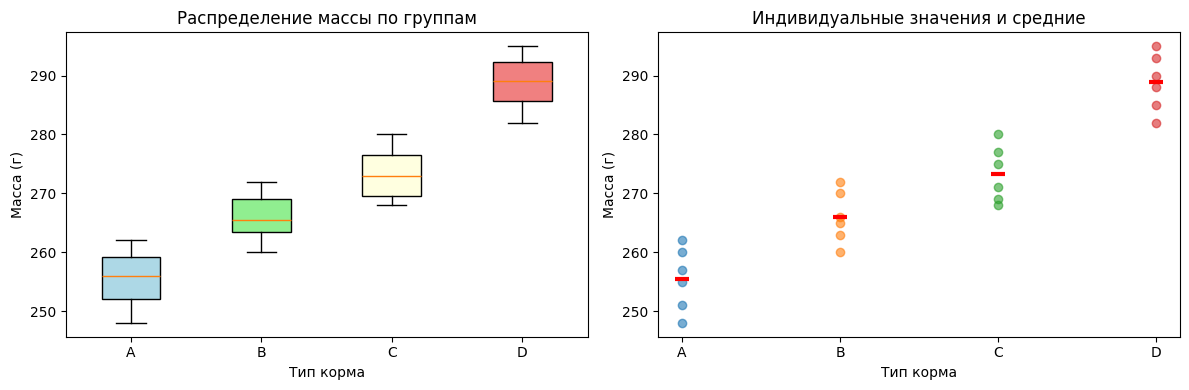


=== Описательная статистика ===
Группа A: среднее=255.5, СКО=5.32
Группа B: среднее=266.0, СКО=4.43
Группа C: среднее=273.3, СКО=4.76
Группа D: среднее=288.8, СКО=4.88

=== Тест Шапиро-Уилка ===
Группа A: p=0.8799
Группа B: p=0.9168
Группа C: p=0.6488
Группа D: p=0.9415

=== Тест Левена ===
p-value: 0.9417
Дисперсии однородны

=== ANOVA ===
F = 49.9246, p = 1.80e-09

Таблица ANOVA:
SS_between=3532.17, SS_within=471.67, SS_total=4003.83
MS_between=1177.39, MS_within=23.58

=== Tukey HSD ===
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B     10.5 0.0064  2.6524 18.3476   True
     A      C  17.8333    0.0  9.9858 25.6809   True
     A      D  33.3333    0.0 25.4858 41.1809   True
     B      C   7.3333 0.0723 -0.5142 15.1809  False
     B      D  22.8333    0.0 14.9858 30.6809   True
     C      D     15.5 0.0001  7.6524 23.3476   True
---------------------------

In [72]:
A = [251,262,248,255,260,257]
B = [263,270,265,272,260,266]
C = [268,275,271,280,277,269]
D = [282,290,285,295,288,293]

data = np.array(A + B + C + D)
groups = ['A']*6 + ['B']*6 + ['C']*6 + ['D']*6

print("=== Визуализация данных ===")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

bp = axes[0].boxplot([A, B, C, D], tick_labels=['A', 'B', 'C', 'D'], patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0].set_xlabel('Тип корма')
axes[0].set_ylabel('Масса (г)')
axes[0].set_title('Распределение массы по группам')

for i, (grp, label) in enumerate(zip([A, B, C, D], ['A', 'B', 'C', 'D'])):
    axes[1].scatter([i+1]*len(grp), grp, alpha=0.6, label=label)
    axes[1].scatter(i+1, np.mean(grp), color='red', s=100, marker='_', linewidths=3)
axes[1].set_xticks([1,2,3,4])
axes[1].set_xticklabels(['A', 'B', 'C', 'D'])
axes[1].set_xlabel('Тип корма')
axes[1].set_ylabel('Масса (г)')
axes[1].set_title('Индивидуальные значения и средние')
plt.tight_layout()
plt.show()

print("\n=== Описательная статистика ===")
for name, grp in [('A', A), ('B', B), ('C', C), ('D', D)]:
    print(f"Группа {name}: среднее={np.mean(grp):.1f}, СКО={np.std(grp, ddof=1):.2f}")

print("\n=== Тест Шапиро-Уилка ===")
for name, grp in [('A', A), ('B', B), ('C', C), ('D', D)]:
    stat, p = st.shapiro(grp)
    print(f"Группа {name}: p={p:.4f}")

print("\n=== Тест Левена ===")
levene_stat, levene_p = st.levene(A, B, C, D)
print(f"p-value: {levene_p:.4f}")
print(f"Дисперсии {'однородны' if levene_p > 0.05 else 'неоднородны'}")

print("\n=== ANOVA ===")
f_stat, anova_p = st.f_oneway(A, B, C, D)
print(f"F = {f_stat:.4f}, p = {anova_p:.2e}")

n = len(data)
k = 4
grand_mean = np.mean(data)

SS_between = sum(len(grp) * (np.mean(grp) - grand_mean)**2 for grp in [A, B, C, D])
SS_within = sum(sum((x - np.mean(grp))**2 for x in grp) for grp in [A, B, C, D])
SS_total = SS_between + SS_within

df_between = k - 1
df_within = n - k
MS_between = SS_between / df_between
MS_within = SS_within / df_within

print("\nТаблица ANOVA:")
print(f"SS_between={SS_between:.2f}, SS_within={SS_within:.2f}, SS_total={SS_total:.2f}")
print(f"MS_between={MS_between:.2f}, MS_within={MS_within:.2f}")

print("\n=== Tukey HSD ===")
tukey = pairwise_tukeyhsd(data, groups, alpha=0.05)
print(tukey)

print("\n=== Размер эффекта ===")
eta_squared = SS_between / SS_total
print(f"eta^2 = {eta_squared:.4f}")

if eta_squared < 0.06:
    effect_interp = "малый"
elif eta_squared < 0.14:
    effect_interp = "средний"
else:
    effect_interp = "большой"
print(f"Эффект: {effect_interp}")
print(f"Корм объясняет {eta_squared*100:.1f}% вариации массы")

Вопрос: Влияет ли тип корма на массу животных?

Описательная статистика:
- A: среднее=255.5 г
- B: среднее=266.0 г
- C: среднее=273.3 г
- D: среднее=288.8 г

Проверка допущений:
- Нормальность: все группы p > 0.05, ОК
- Дисперсии: Левен p=0.9417 > 0.05, однородны

Результаты ANOVA:
- F = 49.92
- p = 1.80e-09 (очень мало)
- H0 отвергается, корма влияют на массу

Tukey HSD post-hoc:
- A vs B: p=0.0064, значимо
- A vs C: p<0.001, значимо
- A vs D: p<0.001, значимо
- B vs C: p=0.0723, НЕ значимо
- B vs D: p<0.001, значимо
- C vs D: p=0.0001, значимо

Размер эффекта:
eta^2 = 0.88 (большой), корм объясняет 88% вариации массы.

Вывод:
Корм D лучший (288.8 г). Все корма отличаются от A, кроме пары B-C.

### Задание 8. Планирование эксперимента: размер выборки и мощность

Планируется эксперимент с $l = 4$ группами. Требуется обеспечить мощность $1 - \beta = 0.8$
для обнаружения разницы $\Delta = 0.5\sigma$ между любыми парами групп
(равный размер групп $n$), при $\alpha = 0.05$.

**Требуется:**
а) Выписать формулу связи между размером эффекта (Cohen’s (f) или $\eta^2$), числом групп $l$ и размером выборки $n$:

$$
f = \sqrt{\frac{\eta^2}{1 - \eta^2}}, \quad \eta^2 = \frac{f^2}{1 + f^2}.
$$

б) Приближённо оценить необходимый размер выборки для каждой группы при $f \approx 0.25$ (средний эффект по Cohen).

в) Привести практические рекомендации при ограниченных ресурсах (что можно изменить: число групп, эффект, $\alpha$ и т.п.).

> Подсказка: можно использовать модуль `from statsmodels.stats.power import FTestAnovaPower`

In [73]:
alpha = 0.05
power = 0.8
f = 0.25
k = 4

print("=== Формулы связи ===")
print("Cohen's f = sqrt(eta^2 / (1 - eta^2))")
print("eta^2 = f^2 / (1 + f^2)")
print("")
print("Для ANOVA:")
print("  df1 = k - 1")
print("  df2 = k(n - 1)")
print("")

eta_sq = f**2 / (1 + f**2)
print(f"При f = {f}:")
print(f"  eta^2 = {eta_sq:.4f}")
print(f"  Фактор объясняет {eta_sq*100:.1f}% дисперсии")

print("\n=== Расчет размера выборки ===")
print(f"Параметры: k={k}, alpha={alpha}, мощность={power}, f={f}")

power_analysis = FTestAnovaPower()
n_per_group = power_analysis.solve_power(effect_size=f, k_groups=k, alpha=alpha, power=power)

print(f"\nРезультат:")
print(f"  Необходимый размер выборки на группу: n = {n_per_group:.1f}")
print(f"  Общий размер выборки: N = {n_per_group * k:.0f}")

achieved_power = power_analysis.power(effect_size=f, k_groups=k, alpha=alpha, nobs=int(np.ceil(n_per_group)))
print(f"  Проверка: достигаемая мощность при n={int(np.ceil(n_per_group))}: {achieved_power:.4f}")

# Таблица зависимости размера выборки от эффекта
print("\n=== Таблица: размер выборки для разных величин эффекта ===")
print(f"{'Эффект (f)':<12} {'Категория':<15} {'n на группу':<15} {'N всего':<10}")
print("-" * 55)
for effect, name in [(0.10, 'малый'), (0.25, 'средний'), (0.40, 'большой')]:
    n = power_analysis.solve_power(effect_size=effect, k_groups=k, alpha=alpha, power=power)
    print(f"{effect:<12} {name:<15} {n:<15.1f} {n*k:<10.0f}")

print("\n=== Рекомендации ===")
print("""
1. Уменьшить число групп
2. Обосновать больший ожидаемый эффект
3. Снизить мощность до 0.70
4. Увеличить alpha до 0.10
5. Использовать повторные измерения
""")

=== Формулы связи ===
Cohen's f = sqrt(eta^2 / (1 - eta^2))
eta^2 = f^2 / (1 + f^2)

Для ANOVA:
  df1 = k - 1
  df2 = k(n - 1)

При f = 0.25:
  eta^2 = 0.0588
  Фактор объясняет 5.9% дисперсии

=== Расчет размера выборки ===
Параметры: k=4, alpha=0.05, мощность=0.8, f=0.25

Результат:
  Необходимый размер выборки на группу: n = 178.4
  Общий размер выборки: N = 714
  Проверка: достигаемая мощность при n=179: 0.8015

=== Таблица: размер выборки для разных величин эффекта ===
Эффект (f)   Категория       n на группу     N всего   
-------------------------------------------------------
0.1          малый           1094.2          4377      
0.25         средний         178.4           714       
0.4          большой         72.2            289       

=== Рекомендации ===

1. Уменьшить число групп
2. Обосновать больший ожидаемый эффект
3. Снизить мощность до 0.70
4. Увеличить alpha до 0.10
5. Использовать повторные измерения



Формулы:
- f = sqrt(eta^2 / (1 - eta^2))
- eta^2 = f^2 / (1 + f^2)

При f = 0.25: eta^2 = 0.059 (фактор объясняет 5.9% дисперсии).

Размер выборки (4 группы, alpha=0.05, мощность=0.80):
- Малый эффект (f=0.10): n=1094 на группу, всего 4377
- Средний эффект (f=0.25): n=179 на группу, всего 714
- Большой эффект (f=0.40): n=73 на группу, всего 289

Рекомендации при ограниченных ресурсах:
1. Уменьшить число групп
2. Обосновать больший ожидаемый эффект
3. Допустить мощность 0.70 вместо 0.80
4. Увеличить alpha до 0.10
5. Использовать повторные измерения

Вывод:
Планирование выборки важно. При f=0.25 нужно около 179 человек на группу.

### Полезные подсказки и библиотеки
- Проверки: `scipy.stats.shapiro`, `scipy.stats.levene`, `scipy.stats.ttest_ind`, `scipy.stats.ttest_rel`, `scipy.stats.wilcoxon`.
- ANOVA: `statsmodels.formula.api` (ols + anova_lm), `pingouin.anova`, `scipy` (ограничено).
- Post-hoc: `statsmodels.stats.multicomp.pairwise_tukeyhsd`, `scikit-posthocs` для Games-Howell.
- Power analysis: `statsmodels.stats.power.FTestAnovaPower`.